# Timing Functions

This notebook has the results of timing various CSR functions.  It uses the data produced by the benchmark suite and saved in `bench.json`; to prepare that data, run:

    python -m pytest --benchmark-only

In [1]:
import json
import numpy as np
import scipy.sparse as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's load the benchmark data:

In [2]:
with open('bench.json', 'r') as jsf:
    data = json.load(jsf)
list(data.keys())

['machine_info', 'commit_info', 'benchmarks', 'datetime', 'version']

And define a function to get the various benchmark runs:

In [3]:
def get_runs(group, *params):
    marks = [b for b in data['benchmarks'] if b['group'] == group]
    ps = ['kernel'] + list(params)
    runs = {}
    for b in data['benchmarks']:
        if b['group'] != group:
            continue
        
        key = tuple(b['params'][p] for p in ps)
        runs[key] = pd.Series(b['stats']['data'], name='time')
    
    runs = pd.concat(runs, names=ps)
    runs = runs.reset_index(ps)
    runs = runs.reset_index(drop=True)
    return runs

In [4]:
get_runs('MultAB')

,kernel,time
0,scipy,0.000808
1,scipy,0.000810
2,scipy,0.000804
3,scipy,0.000805
4,scipy,0.000806
...,...,...
26736,mkl,0.000245
26737,mkl,0.000216
26738,mkl,0.000209
26739,mkl,0.000202


## Matrix Multiplication

Our first benchmark is a simple matrix multiplication.

In [5]:
mab = get_runs('MultAB')
mab['time'] *= 1000
mab.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
mkl,14331.0,0.227966,0.034474,0.1657,0.2073,0.2191,0.237300,0.5052
numba,6274.0,0.811788,0.126416,0.7425,0.7546,0.7680,0.794775,1.8548
scipy,6136.0,0.795902,0.059168,0.7657,0.7723,0.7757,0.785800,1.6409


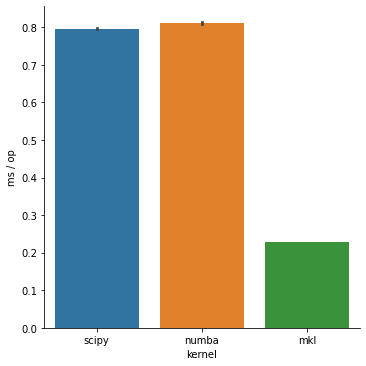

In [7]:
sns.catplot(data=mab, x='kernel', y='time', kind='bar')
plt.ylabel('ms / op')
plt.show()

And multiplying by the transpose:

In [8]:
mab = get_runs('MultABt')
mab['time'] *= 1000
mab.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
mkl,13874.0,0.309582,0.025725,0.2535,0.292925,0.3062,0.3209,0.6842
numba,5790.0,0.845447,0.083694,0.7972,0.806800,0.8214,0.8408,1.7381
scipy,4730.0,0.969985,0.101039,0.9129,0.926500,0.9392,0.9520,2.2749


[]

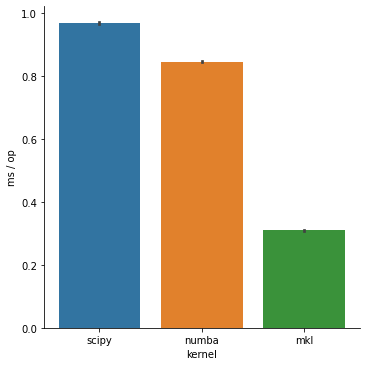

In [9]:
sns.catplot(data=mab, x='kernel', y='time', kind='bar')
plt.ylabel('ms / op')
plt.plot()

### Sweep by Density

We now measure sweeping a 100x100 square matrix multiply by increasing density.

In [10]:
dens = get_runs('MultAB-Density', 'density')
dens['time'] *= 1000

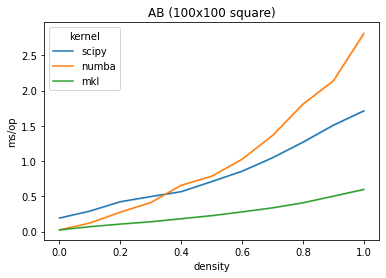

In [11]:
sns.lineplot(data=dens, x='density', y='time', hue='kernel')
plt.title('AB (100x100 square)')
plt.ylabel('ms/op')
plt.show()

And the transpose:

In [14]:
dens = get_runs('MultABt-Density', 'density')
dens['time'] *= 1000

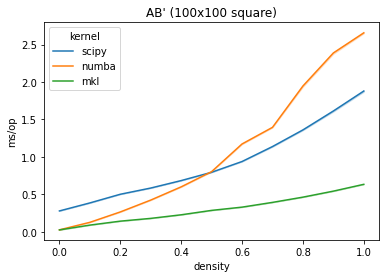

In [15]:
sns.lineplot(data=dens, x='density', y='time', hue='kernel')
plt.title('AB\' (100x100 square)')
plt.ylabel('ms/op')
plt.show()

### Sweep by Size

We now measure sweeping a 10% square matrix multiply by increasing size.

In [16]:
sizes = get_runs('MultAB-Size', 'size')
sizes['time'] *= 1000

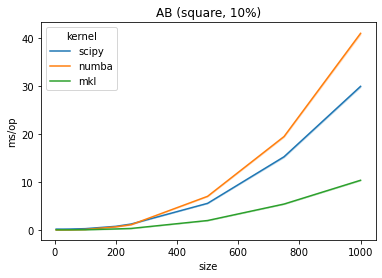

In [17]:
sns.lineplot(data=sizes, x='size', y='time', hue='kernel')
plt.title('AB (square, 10%)')
plt.ylabel('ms/op')
plt.show()

## Matrix-Vector Multiplication

Now we'll look at matrix/vector multiplication ($A\vec{x}$)

In [18]:
muax = get_runs('MultAx')
muax['time'] *= 1000
muax.groupby('kernel')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
kernel,,,,,,,,
mkl,70722.0,0.016522,0.005273,0.0128,0.0140,0.0145,0.0180,0.1883
numba,149254.0,0.012597,0.002766,0.0118,0.0122,0.0123,0.0124,0.1481
scipy,31606.0,0.054542,0.008506,0.0511,0.0525,0.0529,0.0535,0.2450


In [ ]:
sns.catplot(data=muax, x='kernel', y='time', kind='bar')
plt.ylabel('ms / op')
plt.show()